In [1]:
# Importation des librairies
import os
import json
import random
import nltk
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import joblib
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import threading
from tkinter import *
from tkinter import scrolledtext

print('Toutes les librairies ont été importées avec succès !')
print('='*50)


Toutes les librairies ont été importées avec succès !


In [ ]:
"""# Charger l'ensemble de données
with open('data/healthcare.json','r',encoding='utf-8') as f:
    data = json.load(f)

intents = {'intents':[]}
#
for convo in data:
    tag = convo.get("agent_selected_tool", "general").replace(" ","_").lower()


    pattern = convo.get("user_1", "")
    response = convo.get("agent_initial_response", "")


    if pattern and response:
        intents['intents'].append({
            "tag":tag,
            "patterns":[pattern],
            "responses":[response]
        })

# Save the new dataset
with open("data/healthcare_intents.json", "w", encoding="utf-8") as f:
    json.dump(intents, f, indent=4)


print("Les intentions de l'ensemble de données ont été créées avec succès !")"""
    








Les intentions de l'ensemble de données ont été créées avec succès !


In [2]:
# Classe principale du Modele
class ChatbotModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.drop = nn.Dropout(0.4)
        self.out = nn.Linear(64, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.drop(x)
        x = self.relu(self.fc4(x))
        x = self.out(x)  
        return x


# Comparaison entre différents modèles

In [ ]:


# Assistant chatbot
class ChatbotAssistant:
    def __init__(self, intents_path, function_mappings=None, device=None):
        self.intents_path = intents_path
        self.function_mappings = function_mappings

        self.documents = []
        self.intents = []
        self.intents_responses = {}

        self.vectorizer = None
        self.label_names = None
        self.model = None

        self.X = None
        self.y = None

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        for r in ["punkt", "wordnet", "omw-1.4", "stopwords"]:
            try:
                nltk.data.find(f"corpora/{r}")
            except LookupError:
                nltk.download(r)

    
    # Prétraitement du texte
    @staticmethod
    def preprocess_text(text):
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words("english"))
        if not isinstance(text, str):
            return ""
        tokens = nltk.word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(lemmas)

    
    
    # Analyser les intentions
    def parse_intents(self):
        if not os.path.exists(self.intents_path):
            raise FileNotFoundError(f"File not found: {self.intents_path}")

        with open(self.intents_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        self.documents = []
        self.intents = []
        self.intents_responses = {}

        for intent in data.get("intents", []):
            tag = intent.get("tag")
            if tag is None:
                continue
            if tag not in self.intents:
                self.intents.append(tag)
                self.intents_responses[tag] = intent.get("responses", [])

            for pattern in intent.get("patterns", []):
                cleaned = self.preprocess_text(pattern)
                self.documents.append((cleaned, tag))

        print(f"Loaded {len(self.documents)} patterns across {len(self.intents)} intents.")

    
    
    # Créer des caractéristiques TF-IDF
    def build_features(self, max_features=2000):
        texts = [doc[0] for doc in self.documents]
        tags = [doc[1] for doc in self.documents]

        self.label_names = sorted(list(set(self.intents)))
        tag_to_idx = {t: i for i, t in enumerate(self.label_names)}
        self.y = np.array([tag_to_idx[t] for t in tags])

        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.X = self.vectorizer.fit_transform(texts).toarray()
        print(f"TF-IDF built: X.shape={self.X.shape}, y.shape={self.y.shape}")

        
     
    # Entraîner et comparer des modèles
    def compare_models(self, test_size=0.2, random_state=42, max_features=2000):
        """Compare plusieurs modèles ML sur le même dataset (TF-IDF)."""
    

        try:
            from xgboost import XGBClassifier
            xgb_available = True
        except ImportError:
            print(" XGBoost not installed, skipping it.")
            xgb_available = False

        # Préparation des données
        if self.X is None or self.y is None:
            self.build_features(max_features=max_features)
        # Filtrer les classes rares (<2 exemples)
        cnt = Counter(self.y)
        valid = [cls for cls, c in cnt.items() if c >= 2]

        if len(valid) < 2:
            raise ValueError("Il n'y a pas assez de classes valides avec au moins 2 échantillons chacune !")

        mask = np.isin(self.y, valid)
        self.X = self.X[mask]
        self.y = self.y[mask]

        print(f"Filtered dataset: {len(self.y)} samples, {len(valid)} valid classes")

        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state,
            stratify=self.y if len(set(self.y)) > 1 else None
        )

        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
            "SVM": LinearSVC(),
            "Naive Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
            "KNN": KNeighborsClassifier(n_neighbors=5),
            "MLP (Sklearn)": MLPClassifier(hidden_layer_sizes=(512, 256, 128),
                                        activation='relu', max_iter=300, random_state=42)
        }

        if xgb_available:
            models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

        results = {}
        print("\n Comparaison des modèles...\n")

        for name, model in models.items():
            print(f"\n Training {name} ...")
            start = time.time()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            elapsed = time.time() - start
            results[name] = acc
            print(f" Accuracy: {acc:.4f}  |  Time: {elapsed:.2f}s")
            print(classification_report(y_test, preds, zero_division=0))


        
        # --- Comparaison avec Neural Network (Torch)
        print("\n Neural Network (Torch)")
        input_size = self.X.shape[1]
        output_size = len(self.label_names)
        model = ChatbotModel(input_size, output_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_test_t = torch.tensor(X_test, dtype=torch.float32)
        y_test_t = torch.tensor(y_test, dtype=torch.long)
        train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)

        for epoch in range(50):
            model.train()
            running_loss = 0.0
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                out = model(Xb)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch {epoch+1}/50 | Loss: {running_loss/len(train_loader):.4f}")

        model.eval()
        with torch.no_grad():
            preds_nn = torch.argmax(model(X_test_t), dim=1).numpy()

        acc_nn = accuracy_score(y_test, preds_nn)
        results["Neural Network"] = acc_nn
        print("\n Précision des réseaux neuronaux:", acc_nn)
        unique_labels = np.unique(y_test)
        filtered_names = [self.label_names[i] for i in unique_labels if i < len(self.label_names)]
        print(classification_report(y_test, preds_nn, labels=unique_labels, target_names=filtered_names))

        # Résumé global
        print("\n Résumé de la comparaison des modèles:")
        for k, v in results.items():
            print(f"{k:<25} → {v:.4f}")

        best_model = max(results, key=results.get)
        print(f"\n Best model: {best_model} with accuracy = {results[best_model]:.4f}")

        # Graphique comparatif
        plt.figure(figsize=(10, 6))
        plt.barh(list(results.keys()), list(results.values()), color='skyblue')
        plt.xlabel("Accuracy")
        plt.title("Comparaison des modèles")
        plt.grid(axis="x", linestyle="--", alpha=0.7)
        plt.show()

        return results



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Calixte\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Calixte\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Calixte\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loaded 758 patterns across 137 intents.
TF-IDF built: X.shape=(758, 852), y.shape=(758,)
 XGBoost not installed, skipping it.
Filtered dataset: 690 samples, 69 valid classes

 Comparaison des modèles...


 Training Logistic Regression ...
 Accuracy: 0.6232  |  Time: 47.91s
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           9       0.80      1.00      0.89         8
          10       0.00      0.00      0.00         1
          11       0.25      0.40      0.31         5
          12       0.00      0.00      0.00         1
          13       0.67      1.00      0.80         2
          14       0.00      0.00      0.00         1
          16       0.80      1.00      0.89         8
          20       0.00      0.00      0.00         2
          21       1.00

c:\Users\Calixte\Documents\Capstone-Chatbot-Intelligent\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Calixte\Documents\Capstone-Chatbot-Intelligent\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Calixte\Documents\Capstone-Chatbot-Intelligent\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

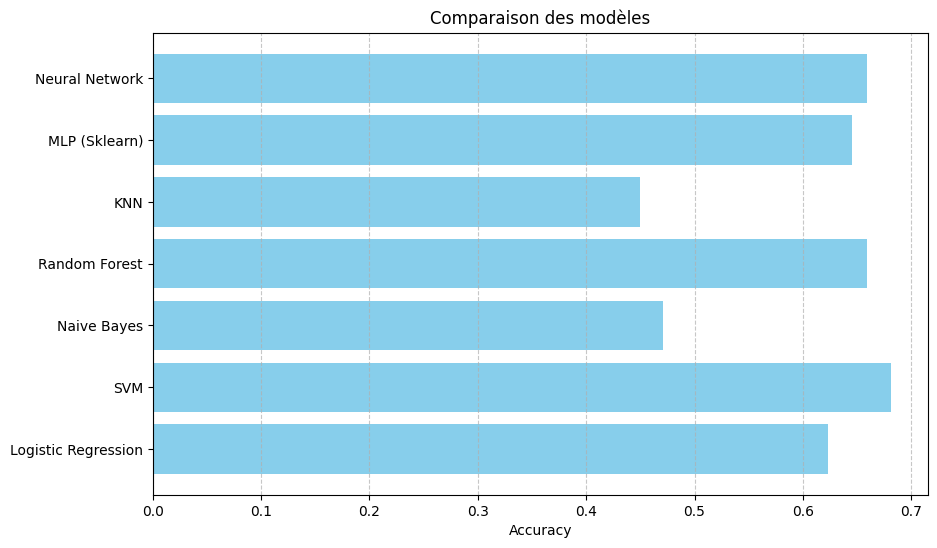

In [70]:
# Exécution
assistant = ChatbotAssistant("data/healthcare_intents.json")
assistant.parse_intents()
assistant.build_features(max_features=2000)

results = assistant.compare_models()


# Choix du meilleur modèle
    Après avoir comparé plusieurs modèles sur la base de leur taux de précision (Accuracy), nous avons décidé d’entraîner nos données à l’aide de deux modèles : un réseau de neurones (Neural Network) et une machine à vecteurs de support (SVM).
    Le SVM a été retenu car il a obtenu la meilleure précision globale parmi les modèles testés.
    Le Neural Network, quant à lui, a été conservé puisque ses performances étaient proches de celles du SVM, et qu’il représente le modèle initialement prévu dans la conception de notre chatbot.


In [3]:
# Classe principale du Chatbot
    
class ChatbotAssistant:
    def __init__(self, intents_path, function_mappings=None, device=None):
        self.intents_path = intents_path
        self.function_mappings = function_mappings

        self.documents = []              
        self.intents = []                
        self.intents_responses = {}      

        
        self.vectorizer = None
        self.label_names = None
        self.model = None

        
        self.X = None
        self.y = None

        
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    
    # Prétraitement du texte
    @staticmethod
    def preprocess_text(text):
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        if not isinstance(text, str):
            return ""
        tokens = nltk.word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(lemmas)

    
    
    # Chargement du fichier intents.json
    def parse_intents(self):
        if not os.path.exists(self.intents_path):
            raise FileNotFoundError(f"File not found: {self.intents_path}")

        with open(self.intents_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        self.documents = []
        self.intents = []
        self.intents_responses = {}

        for intent in data.get("intents", []):
            tag = intent.get("tag")
            if tag is None:
                continue
            if tag not in self.intents:
                self.intents.append(tag)
                self.intents_responses[tag] = intent.get("responses", [])

            for pattern in intent.get("patterns", []):
                cleaned = self.preprocess_text(pattern)
               
                self.documents.append((cleaned, tag))

        print(f"Loaded {len(self.documents)} patterns across {len(self.intents)} intents.")

    
    
    #  Vectorisation TF-IDF
    def build_features(self, max_features=2000):
        texts = [doc[0] for doc in self.documents]
        tags = [doc[1] for doc in self.documents]

        
        self.label_names = sorted(list(set(self.intents)))
        tag_to_idx = {t: i for i, t in enumerate(self.label_names)}
        self.y = np.array([tag_to_idx[t] for t in tags])

        
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        X = self.vectorizer.fit_transform(texts).toarray()
        self.X = X
        print(f"TF-IDF built: X.shape = {self.X.shape}, y.shape = {self.y.shape}")

        cnt = Counter(self.y)
        valid = [cls for cls, c in cnt.items() if c >= 2]
        mask = np.isin(self.y, valid)
        self.X = self.X[mask]
        self.y = self.y[mask]
        print("Filtered shapes:", self.X.shape, self.y.shape)

        old_label_names = self.label_names
        new_label_names = [old_label_names[i] for i in valid]

        old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(valid)}

        self.y = np.array([old_to_new[int(old)] for old in self.y if int(old) in old_to_new])

        self.label_names = new_label_names
        
        print(f"Nouvelle taille de label_names : {len(self.label_names)}")
   
    
    #  Entraînement du modèle
    def train_model(self,
                    batch_size=32,
                    lr=1e-3,
                    epochs=50,
                    max_features=2000,
                    test_size=0.2,
                    scheduler_step=None,
                    scheduler_gamma=0.8,
                    random_state=42):
        
        if self.X is None or self.y is None:
            print("Building features (TF-IDF)...")
            self.build_features(max_features=max_features)

    # Filtrer les classes rares (<2 exemples)
        cnt = Counter(self.y)
        valid = [cls for cls, c in cnt.items() if c >= 2]

        if len(valid) < 2:
            raise ValueError("Il n'y a pas assez de classes valides avec au moins 2 échantillons chacune !")

        mask = np.isin(self.y, valid)
        self.X = self.X[mask]
        self.y = self.y[mask]

        print(f"Filtered dataset: {len(self.y)} samples, {len(valid)} valid classes")

        #   Split train/test
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state,
            stratify=self.y if len(set(self.y)) > 1 else None
    )
        print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

        # Données Tensor
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train, dtype=torch.long)
        X_test_t = torch.tensor(X_test, dtype=torch.float32)
        y_test_t = torch.tensor(y_test, dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                              batch_size=batch_size, shuffle=True)

        # Création du modèle
        input_size = self.X.shape[1]
        output_size = len(valid)  

        self.model = ChatbotModel(input_size, output_size)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

        # Entraînement
        print("\n Starting training...\n")
        loss_values = []

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0

            for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            scheduler.step()
            epoch_loss = running_loss / len(train_loader)
            loss_values.append(epoch_loss)
            print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        # Loss Graphe
        plt.figure(figsize=(8, 5))
        plt.plot(loss_values, label="Training Loss", color="blue")
        plt.title("Training Loss Curve")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Evaluation
        self.model.eval()
        with torch.no_grad():
            preds = torch.argmax(self.model(X_test_t), dim=1).numpy()

        acc = accuracy_score(y_test, preds)
        print("\n=== Test set evaluation ===")
        print(f"Accuracy: {acc:.4f}")

    #   Mettre à jour les noms d’intents valides
        unique_labels = np.unique(y_test)
        filtered_names = [self.label_names[i] for i in unique_labels if i < len(self.label_names)]

        print(classification_report(
        y_test, preds,
        labels=unique_labels,
        target_names=filtered_names,
        zero_division=0
    ))

        print("\n Model training + evaluation complete.")

         
        print("Model training + evaluation complete.")
        unique_labels = np.unique(y_test)
        filtered_names = [self.label_names[i] for i in unique_labels]
    
    
    # Sauvegarde / Chargement
    def save_all(self, model_path="chat_model.pth", meta_path="meta.pkl"):
        torch.save(self.model.state_dict(), model_path)
        meta = {
            "label_names": self.label_names,
            "vectorizer": self.vectorizer  
        }
        
        with open(meta_path, "wb") as f:
            pickle.dump(meta, f)
        print(f"Saved model to {model_path} and meta to {meta_path}.")

    def load_all(self, model_path="chat_model_tfidf.pth", meta_path="meta_tfidf.pkl"):
        with open(meta_path, "rb") as f:
            meta = pickle.load(f)
        self.label_names = meta["label_names"]
        self.vectorizer = meta["vectorizer"]
        input_size = self.vectorizer.max_features if hasattr(self.vectorizer, "max_features") and self.vectorizer.max_features is not None else self.vectorizer.vocabulary_.__len__()
        
        input_size = len(self.vectorizer.get_feature_names_out())
        output_size = len(self.label_names)
        self.model = ChatbotModel(input_size, output_size).to(self.device)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        print(f"Loaded model and meta from {model_path}, {meta_path}.")

    
    
    # Interaction avec l'utilisateur
    def process_message(self, input_message, threshold=0.65, log_uncertain=True):
        if self.model is None or self.vectorizer is None:
            raise RuntimeError("Modèle ou vectoriseur non chargé. Appelez d'abord train_model() ou load_all().")

        cleaned = self.preprocess_text(input_message)
        vec = self.vectorizer.transform([cleaned]).toarray()
        input_t = torch.tensor(vec, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            logits = self.model(input_t)
            probs = F.softmax(logits, dim=1)
            confidence, idx = torch.max(probs, dim=1)
            confidence = confidence.item()
            pred_idx = idx.item()
            predicted_intent = self.label_names[pred_idx]

        if confidence >= threshold:
            
            resp = random.choice(self.intents_responses.get(predicted_intent, ["Sorry, I don't have a response."]))
            return f"({confidence*100:.1f}% confident) {resp}"
        else:
            if log_uncertain:
                with open("uncertain_inputs.log", "a", encoding="utf-8") as f:
                    f.write(input_message.strip() + "\n")
            return "I'm not sure I understood that. Could you rephrase?"



 


Loaded 758 patterns across 137 intents.
Building features (TF-IDF)...
TF-IDF built: X.shape = (758, 852), y.shape = (758,)
Filtered shapes: (690, 852) (690,)
Nouvelle taille de label_names : 69
Filtered dataset: 690 samples, 69 valid classes
Train samples: 552, Test samples: 138

 Starting training...



Epoch 1/50 | Loss: 4.1515 | LR: 0.001000


Epoch 2/50 | Loss: 3.7816 | LR: 0.001000


Epoch 3/50 | Loss: 3.1842 | LR: 0.001000


Epoch 4/50 | Loss: 2.7085 | LR: 0.001000


Epoch 5/50 | Loss: 2.3822 | LR: 0.001000


Epoch 6/50 | Loss: 2.1801 | LR: 0.001000


Epoch 7/50 | Loss: 1.9337 | LR: 0.001000


Epoch 8/50 | Loss: 1.7044 | LR: 0.001000


Epoch 9/50 | Loss: 1.6519 | LR: 0.001000


Epoch 10/50 | Loss: 1.4828 | LR: 0.001000


Epoch 11/50 | Loss: 1.2972 | LR: 0.001000


Epoch 12/50 | Loss: 1.2762 | LR: 0.001000


Epoch 13/50 | Loss: 1.1285 | LR: 0.001000


Epoch 14/50 | Loss: 1.0156 | LR: 0.001000


Epoch 15/50 | Loss: 0.9834 | LR: 0.000800


Epoch 16/50 | Loss: 0.9330 | LR: 0.000800


Epoch 17/50 | Loss: 0.9071 | LR: 0.000800


Epoch 18/50 | Loss: 0.8152 | LR: 0.000800


Epoch 19/50 | Loss: 0.7854 | LR: 0.000800


Epoch 20/50 | Loss: 0.7461 | LR: 0.000800


Epoch 21/50 | Loss: 0.6885 | LR: 0.000800


Epoch 22/50 | Loss: 0.6905 | LR: 0.000800


Epoch 23/50 | Loss: 0.5815 | LR: 0.000800


Epoch 24/50 | Loss: 0.5805 | LR: 0.000800


Epoch 25/50 | Loss: 0.5248 | LR: 0.000800


Epoch 26/50 | Loss: 0.4534 | LR: 0.000800


Epoch 27/50 | Loss: 0.4579 | LR: 0.000800


Epoch 28/50 | Loss: 0.4604 | LR: 0.000800


Epoch 29/50 | Loss: 0.4191 | LR: 0.000800


Epoch 30/50 | Loss: 0.3802 | LR: 0.000640


Epoch 31/50 | Loss: 0.3447 | LR: 0.000640


Epoch 32/50 | Loss: 0.3154 | LR: 0.000640


Epoch 33/50 | Loss: 0.3705 | LR: 0.000640


Epoch 34/50 | Loss: 0.3010 | LR: 0.000640


Epoch 35/50 | Loss: 0.3002 | LR: 0.000640


Epoch 36/50 | Loss: 0.2470 | LR: 0.000640


Epoch 37/50 | Loss: 0.2547 | LR: 0.000640


Epoch 38/50 | Loss: 0.2392 | LR: 0.000640


Epoch 39/50 | Loss: 0.2720 | LR: 0.000640


Epoch 40/50 | Loss: 0.2414 | LR: 0.000640


Epoch 41/50 | Loss: 0.2541 | LR: 0.000640


Epoch 42/50 | Loss: 0.2133 | LR: 0.000640


Epoch 43/50 | Loss: 0.2370 | LR: 0.000640


Epoch 44/50 | Loss: 0.2551 | LR: 0.000640


Epoch 45/50 | Loss: 0.1806 | LR: 0.000512


Epoch 46/50 | Loss: 0.1757 | LR: 0.000512


Epoch 47/50 | Loss: 0.1925 | LR: 0.000512


Epoch 48/50 | Loss: 0.2216 | LR: 0.000512


Epoch 49/50 | Loss: 0.1738 | LR: 0.000512


Epoch 50/50 | Loss: 0.1773 | LR: 0.000512


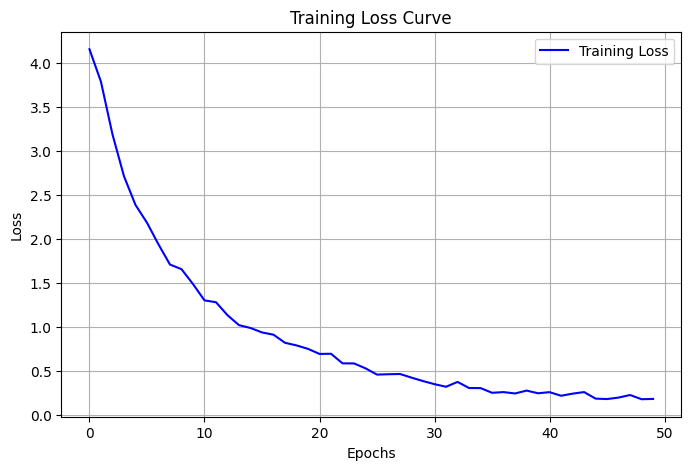


=== Test set evaluation ===
Accuracy: 0.6377
                                    precision    recall  f1-score   support

                   bookappointment       0.33      0.20      0.25         5
             rescheduleappointment       0.70      0.78      0.74         9
                 cancelappointment       0.00      0.00      0.00         2
                  doctorinfolookup       0.75      0.60      0.67         5
                    billingsupport       0.73      1.00      0.84         8
                  emergencycontact       1.00      0.25      0.40         4
                      transfercall       0.00      0.00      0.00         4
                 checkreportstatus       0.89      1.00      0.94         8
                 updatepatientinfo       1.00      0.92      0.96        13
             insuranceclaimsupport       0.83      0.83      0.83         6
                    labtestbooking       1.00      0.67      0.80         3
                prescriptionrefill       

In [4]:
# Exécution

if __name__ == "__main__":
    assistant = ChatbotAssistant("data/healthcare_intents.json")
    assistant.parse_intents()
    
    assistant.train_model(batch_size=32, lr=1e-3, epochs=50, max_features=2000, test_size=0.2, scheduler_step=15, scheduler_gamma=0.8)
    #assistant.save_all("chat_model_tfidf.pth", "meta_tfidf.pkl")

    assistant.load_all('chat_model_tfidf.pth','meta_tfidf.pkl')

     
    print("\nYou can chat. Type /quit to exit.")
    while True:
        msg = input("You: ")
        if msg.strip().lower() == "/quit":
            break
        print("Chatbot:", assistant.process_message(msg, threshold=0.65))

In [5]:

# Classe principale du Chatbot

class ChatbotAssistant:
    def __init__(self, intents_path, function_mappings=None):
        self.intents_path = intents_path
        self.function_mappings = function_mappings

        self.documents = []              
        self.intents = []                
        self.intents_responses = {}      

        self.vectorizer = None
        self.label_names = None
        self.model = None

        self.X = None
        self.y = None


    # Prétraitement du texte
    @staticmethod
    def preprocess_text(text):
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        if not isinstance(text, str):
            return ""
        tokens = nltk.word_tokenize(text.lower())
        tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
        lemmas = [lemmatizer.lemmatize(t) for t in tokens]
        return " ".join(lemmas)


    
    
    # Lecture du fichier intents.json
    def parse_intents(self):
        if not os.path.exists(self.intents_path):
            raise FileNotFoundError(f"File not found: {self.intents_path}")

        with open(self.intents_path, "r", encoding="utf-8") as f:
            data = json.load(f)

        self.documents = []
        self.intents = []
        self.intents_responses = {}

        for intent in data.get("intents", []):
            tag = intent.get("tag")
            if tag is None:
                continue
            if tag not in self.intents:
                self.intents.append(tag)
                self.intents_responses[tag] = intent.get("responses", [])

            for pattern in intent.get("patterns", []):
                cleaned = self.preprocess_text(pattern)
                self.documents.append((cleaned, tag))

        print(f" Loaded {len(self.documents)} patterns across {len(self.intents)} intents.")


    
    
    # Vectorisation TF-IDF
    def build_features(self, max_features=2000):
        texts = [doc[0] for doc in self.documents]
        tags = [doc[1] for doc in self.documents]

        self.label_names = sorted(list(set(self.intents)))
        tag_to_idx = {t: i for i, t in enumerate(self.label_names)}
        self.y = np.array([tag_to_idx[t] for t in tags])

        self.vectorizer = TfidfVectorizer(max_features=max_features)
        X = self.vectorizer.fit_transform(texts).toarray()
        self.X = X
        print(f" TF-IDF built: X.shape = {self.X.shape}, y.shape = {self.y.shape}")

        # Filtrer les classes trop rares
        cnt = Counter(self.y)
        valid = [cls for cls, c in cnt.items() if c >= 2]
        mask = np.isin(self.y, valid)
        self.X = self.X[mask]
        self.y = self.y[mask]

        old_label_names = self.label_names
        new_label_names = [old_label_names[i] for i in valid]
        old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(valid)}
        self.y = np.array([old_to_new[int(old)] for old in self.y if int(old) in old_to_new])
        self.label_names = new_label_names

        print(f" Filtered dataset: {len(self.y)} samples, {len(self.label_names)} valid classes.")


    
    
    # Entraînement du modèle SVM
    def train_model(self, test_size=0.2, random_state=42):
        if self.X is None or self.y is None:
            self.build_features()

        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state, stratify=self.y
        )

        print("\n Training Support Vector Machine...")
        self.model = SVC(kernel="rbf", probability=True, class_weight="balanced", C=2, gamma='scale')

        self.model.fit(X_train, y_train)

        preds = self.model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f" SVM Accuracy: {acc:.4f}")

        unique_labels = np.unique(y_test)
        filtered_names = [self.label_names[i] for i in unique_labels if i < len(self.label_names)]

        print("\n Classification Report:")
        print(classification_report(y_test, preds, labels=unique_labels, target_names=filtered_names, zero_division=0))


    
    
    # Sauvegarde / Chargement avec joblib
    def save_all(self, model_path="svm_model.pkl", meta_path="svm_meta.pkl"):
        joblib.dump(self.model, model_path)
        joblib.dump({
            "vectorizer": self.vectorizer,
            "label_names": self.label_names,
            "intents_responses": self.intents_responses
        }, meta_path)
        print(f" Saved model to {model_path} and meta to {meta_path}.")


    def load_all(self, model_path="svm_model.pkl", meta_path="svm_meta.pkl"):
        self.model = joblib.load(model_path)
        meta = joblib.load(meta_path)
        self.vectorizer = meta["vectorizer"]
        self.label_names = meta["label_names"]
        self.intents_responses = meta["intents_responses"]
        print(f" Loaded model and meta from {model_path}, {meta_path}.")


    
    
    # Prédiction d’un message utilisateur
    def process_message(self, input_message, threshold=0.05, log_uncertain=True):
        if self.model is None or self.vectorizer is None:
            raise RuntimeError("Modèle ou vectoriseur non chargé. Appelez d'abord train_model() ou load_all().")

        cleaned = self.preprocess_text(input_message)
        vec = self.vectorizer.transform([cleaned]).toarray()

        probs = self.model.predict_proba(vec)[0]
        pred_idx = np.argmax(probs)
        confidence = probs[pred_idx]
        predicted_intent = self.label_names[pred_idx]

        if confidence >= threshold:
            resp = random.choice(self.intents_responses.get(predicted_intent, ["Sorry, I don't have a response."]))
            return f"({confidence*100:.1f}% confident) {resp}"
        else:
            if log_uncertain:
                with open("uncertain_inputs.log", "a", encoding="utf-8") as f:
                    f.write(input_message.strip() + "\n")
            return "I'm not sure I understood that. Could you rephrase?"


In [6]:
# Exécution

assistant = ChatbotAssistant("data/healthcare_intents.json")
assistant.parse_intents()
assistant.build_features()
assistant.train_model()

#assistant.save_all("svm_model.pkl", "svm_meta.pkl")

# --- Later ---
assistant.load_all("svm_model.pkl", "svm_meta.pkl")
print("\nYou can chat. Type /quit to exit.")
while True:
    msg = input("You: ")
    if msg.strip().lower() == "/quit":
        break
    print("Chatbot:", assistant.process_message(msg, threshold=0.05))


 Loaded 758 patterns across 137 intents.
 TF-IDF built: X.shape = (758, 852), y.shape = (758,)
 Filtered dataset: 690 samples, 69 valid classes.

 Training Support Vector Machine...
 SVM Accuracy: 0.6014

 Classification Report:
                                    precision    recall  f1-score   support

                   bookappointment       0.25      0.20      0.22         5
             rescheduleappointment       0.75      1.00      0.86         9
                 cancelappointment       0.50      0.50      0.50         2
                  doctorinfolookup       0.13      0.80      0.23         5
                    billingsupport       0.73      1.00      0.84         8
                  emergencycontact       1.00      0.25      0.40         4
                      transfercall       0.00      0.00      0.00         4
                 checkreportstatus       0.88      0.88      0.88         8
                 updatepatientinfo       1.00      1.00      1.00        13
          

In [5]:


# COULEURS ET STYLE

BG_COLOR = "#1E1E1E"
BOT_COLOR = "#2D2D2D"
USER_COLOR = "#0078D7"
TEXT_COLOR = "#EAECEE"
INPUT_COLOR = "#2C2C2C"

FONT = "Helvetica 12"
FONT_BOLD = "Helvetica 12 bold"

BOT_NAME = "MedBot 🤖"

# Application de chat (intégration GUI + modèle)
from __main__ import ChatbotAssistant
class ModernChatApp:
    def __init__(self):
        self.window = Tk()
        self.window.title("MedBot - Healthcare Chat")
        self.window.configure(bg=BG_COLOR)
        self.window.geometry("500x600")
        self.window.resizable(False, False)

        self.setup_ui()

        # Initialiser l'assistant chatbot
        self.assistant = ChatbotAssistant("data/healthcare_intents.json")
        self.assistant.parse_intents()

        # Essayer de charger le modèle s'il est disponible
        if os.path.exists("chat_model_tfidf.pth") and os.path.exists("meta_tfidf.pkl"):
            self.assistant.load_all("chat_model_tfidf.pth", "meta_tfidf.pkl")
            print(" Model loaded successfully.")
        else:
            print("Modèle ou métadonnées introuvables. Veuillez d'abord l'entraîner.")
            

    
    
    # Setup UI components
    def setup_ui(self):
        # Header
        header = Label(self.window, text="💬 MedBot Healthcare Assistant",
                       bg=BG_COLOR, fg="#00A8E8", font=("Helvetica", 15, "bold"), pady=10)
        header.pack(fill=X)

        # Chat display (scrollable)
        self.chat_display = scrolledtext.ScrolledText(
            self.window, wrap=WORD, bg=BOT_COLOR, fg=TEXT_COLOR,
            font=FONT, padx=10, pady=10, state=DISABLED
        )
        self.chat_display.pack(padx=10, pady=10, fill=BOTH, expand=True)

        # Bottom frame (input + send button)
        bottom_frame = Frame(self.window, bg=BG_COLOR)
        bottom_frame.pack(fill=X, side=BOTTOM, pady=5)

        self.msg_entry = Entry(bottom_frame, bg=INPUT_COLOR, fg=TEXT_COLOR,
                               font=FONT, insertbackground=TEXT_COLOR, relief=FLAT)
        self.msg_entry.pack(fill=X, padx=10, pady=10, ipady=8, side=LEFT, expand=True)
        self.msg_entry.bind("<Return>", self.send_message)

        send_btn = Button(bottom_frame, text="Send ➤", bg="#00A8E8",
                          fg="white", font=FONT_BOLD, relief=FLAT,
                          command=lambda: self.send_message(None))
        send_btn.pack(side=RIGHT, padx=10, pady=5)

    
    
    # Envoi de messages et gestion des réponses
    def send_message(self, event):
        msg = self.msg_entry.get().strip()
        if not msg:
            return
        self.msg_entry.delete(0, END)

        self._insert_message(msg, sender="You", align="right", color=USER_COLOR)

        # Simulate typing
        self._insert_message("typing...", sender=BOT_NAME, align="left", color="#777777", temp=True)

        # Run bot response in a separate thread
        threading.Thread(target=self._get_bot_response, args=(msg,)).start()

    def _get_bot_response(self, msg):
        try:
            response = self.assistant.process_message(msg)
        except Exception as e:
            response = f" Error: {e}"

        # Remove "typing..."
        self._delete_last_line()
        self._insert_message(response, sender=BOT_NAME, align="left", color="#00A8E8")

    
    
    # Insertion de messages avec des bulles de discussion
    def _insert_message(self, text, sender, align="left", color="#00A8E8", temp=False):
        self.chat_display.configure(state=NORMAL)

        tag_name = f"{sender}_{align}_{color}"
        self.chat_display.tag_configure(tag_name, justify=align, foreground=color, spacing3=5)

        message = f"{sender}: {text}\n\n"
        self.chat_display.insert(END, message, tag_name)
        self.chat_display.configure(state=DISABLED)
        self.chat_display.see(END)

        # If it's temporary (like "typing..."), mark position
        if temp:
            self.last_temp_index = self.chat_display.index("end-2c")

    def _delete_last_line(self):
        """Remove temporary typing message"""
        self.chat_display.configure(state=NORMAL)
        self.chat_display.delete("end-3l", "end-1l")
        self.chat_display.configure(state=DISABLED)

    def run(self):
        self.window.mainloop()






In [6]:
# Lancer l'application
if __name__ == "__main__":
    app = ModernChatApp()
    app.run()

Loaded 758 patterns across 137 intents.
Loaded model and meta from chat_model_tfidf.pth, meta_tfidf.pkl.
 Model loaded successfully.
